## SCS_3253 Machine Learning - Term Project

## School Safety Zone: Watch Your Speed Program

### Group 6
Students: Aniket Ajit Ingale, Zlata Izvalava

## Notebook 1 - Download, prepare and explore the data

### Dataset: "School Safety Zone Watch Your Speed Program – Detailed Speed Counts"

Source: City of Toronto, Open Data https://open.toronto.ca/dataset/school-safety-zone-watch-your-speed-program-detailed-speed-counts/

The Watch Your Speed Program (WYSP) uses devices called speed display signs or driver feedback signs which contain a radar device and an LED display. These signs are installed on a dedicated wooden pole. The radar measures the speeds of oncoming vehicles and the LED sign displays their speeds to the passing motorists, thereby reminding them to check their speeds and to obey speed limits. The City’s permanent units are installed in Safety Zones. This dataset contains an hourly aggregation of observed speeds for each sign installation in 10km/hr speed range increments. See Location Data for details on where and when signs were installed.

See here for more: https://www.toronto.ca/services-payments/streets-parking-transportation/road-safety/vision-zero/safety-initiatives/safety-zones/

Limitations:
- The count of number of vehicles is not equivalent to a traffic volume count.
- Sign addresses have not been verified
- Does not yet include data for signs removed before August 1st 2019


### Problem

1. Explore the data recorded by the driver feedback sign #230 (approximate address - 994 Jane Street, Toronto; southbound direction of travel; speed limit - 50 km/hr).

2. Train a model to predict hourly count of vehicles with speeds equal to or greater than 50 km/hr in the location where the sign #230 was installed.

Analysis of recorded data and the model can be useful for understanding the situation with safety in this school zone and for planning measures to improve it.

Note: The model cannot be used during the pandemic because the situation in the city has changed (traffic volume has reduced drastically, schools are closed, etc.)

In [22]:
import os
import zipfile
from six.moves import urllib

import numpy as np
import pandas as pd
from datetime import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)

In [23]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [24]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 150)

### Load the data

**1. Read the file with information about sign locations**

Source: City of Toronto, Open Data, School Safety Zone Watch Your Speed Program – Locations 

https://open.toronto.ca/dataset/school-safety-zone-watch-your-speed-program-locations/

This dataset contains the locations and operating parameters for each location where a permanent Watch Your Speed Program sign was installed.
Column descriptions are given on the web page ("Data Features" section)

In [25]:
# Read the file with sign locations info

locations = pd.read_csv('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/4e2221b9-da3a-4ef8-b8eb-17e95b7abaa0?format=csv&projection=4326', 
                        header=0)
locations.head()

,_id,sign_name,flash_speed,end_date,schedule,geometry,speed_limit,min_speed,address,sign_id,strobe_speed,start_date,dir
0,1,Humberwood Blvd NB,41,2017-01-01T23:00:00-05:00,Weekdays from 7 AM - 9 PM,"{u'type': u'Point', u'coordinates': (-79.6200688334, 43.7289179122)}",40,30,850 Humberwood Boulevard,18,46.0,2017-01-01T00:00:00-05:00,NB
1,2,Humberwood Blvd SB,41,2020-02-19T23:00:00-05:00,Weekdays from 7 AM - 9 PM,"{u'type': u'Point', u'coordinates': (-79.619998, 43.729637)}",40,30,7 Hullen Crescent,46,46.0,2019-01-01T00:00:00-05:00,SB
2,3,Kingsview Blvd EB,41,2020-02-19T23:00:00-05:00,Weekdays from 7 AM - 9 PM,"{u'type': u'Point', u'coordinates': (-79.554847, 43.698055)}",40,30,51 Kingsview Boulevard,167,46.0,2019-01-03T14:00:00-05:00,EB
3,4,Kingsview Blvd WB,41,2020-02-19T23:00:00-05:00,Weekdays from 7 AM - 9 PM,"{u'type': u'Point', u'coordinates': (-79.553785, 43.698448)}",40,30,44 Kingsview Boulevard,168,46.0,2019-01-03T14:00:00-05:00,WB
4,5,York Rd EB,51,2020-02-19T23:00:00-05:00,Weekdays from 7 AM - 9 PM,"{u'type': u'Point', u'coordinates': (-79.552668, 43.69957)}",50,30,20 York Road,276,56.0,2019-03-20T09:00:00-04:00,EB


In [26]:
# There are 391 signs

len(locations['sign_id'].unique())

391

In [27]:
# Information about the sign #230:

# Data was collected from 2019-03-20 06:00 to 2020-02-19 23:00
# Speed limit = 50 km/hr
# 'schedule': Times of week when the sign is on. Signs still record speeds when the display is inactive.

location_230 = locations[locations['sign_id'] == 230]
location_230

,_id,sign_name,flash_speed,end_date,schedule,geometry,speed_limit,min_speed,address,sign_id,strobe_speed,start_date,dir
89,90,Jane St SB,51,2020-02-19T23:00:00-05:00,Weekdays from 7 AM - 9 PM,"{u'type': u'Point', u'coordinates': (-79.49836, 43.682598)}",50,30,994 Jane Street,230,56.0,2019-03-20T06:00:00-04:00,SB


**2. Readme file for the "School Safety Zone Watch Your Speed Program – Detailed Speed Counts" data**

Source: City of Toronto, Open Data, School Safety Zone Watch Your Speed Program – Detailed Speed Counts

https://open.toronto.ca/dataset/school-safety-zone-watch-your-speed-program-detailed-speed-counts/

In [28]:
# Readme file for the "School Safety Zone Watch Your Speed Program – Detailed Speed Counts" data contains column descriptions

readme = pd.read_excel('https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/00ee1211-91df-476e-8c9e-8d4b184f25ac', 
                       header=0)
readme

# Note: There is no column named 'ward_no' in the datasets

,DB_column,Description,Note
0,ward_no,Ward number,integer
1,sign_id,Unique id for sign location. To be matched with Sign Locations dataset,integer
2,address,Approximate street address where the sign is located,text
3,dir,Cardinal direction of travel,Text (e.g. NB = North Bound)
4,datetime_bin,Start of the hour during which these observations were made,timestamp
5,speed_bin,"Range of speeds observed (e.g. [10,20) represents speeds from 10km/hr up to and not including 20 km/hr)",integer range
6,volume,Number of vehicles observed in that hour and speed bin,integer


**3. Download the datasets: "School Safety Zone Watch Your Speed Program – Detailed Speed Counts"**

Source: City of Toronto, Open Data, School Safety Zone Watch Your Speed Program – Detailed Speed Counts

https://open.toronto.ca/dataset/school-safety-zone-watch-your-speed-program-detailed-speed-counts/

In [29]:
# Download the datasets

DOWNLOAD_URL_1 = "https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/fbbed422-60da-4f83-92f9-5a0faed233c7"
DATA_PATH_1 = os.path.join("data_school_safety_zones", "stationary_detailed_2019")
ZIP_NAME_1 = "stationary_detailed_2019.zip"

DOWNLOAD_URL_2 = "https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/bdfac238-e4b6-4b0a-8684-b9c161cbe2aa"
DATA_PATH_2 = os.path.join("data_school_safety_zones", "stationary_detailed_2020")
ZIP_NAME_2 = "stationary_detailed_2020.zip"

# Function to fetch the data
def fetch_data(file_url=DOWNLOAD_URL_1, data_path=DATA_PATH_1, zip_name=ZIP_NAME_1):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    zip_path = os.path.join(data_path, zip_name)
    urllib.request.urlretrieve(file_url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip:  
        zip.printdir() # printing all the contents of the zip file
        zip.extractall(path=data_path)
        zip.close()

In [30]:
# Load and extract the 2019 data

fetch_data(file_url=DOWNLOAD_URL_1, data_path=DATA_PATH_1, zip_name=ZIP_NAME_1)

File Name                                             Modified             Size
wys_stationary_detailed_201901.csv             2020-03-04 10:21:30     28388284
wys_stationary_detailed_201902.csv             2020-03-04 10:21:44     26334662
wys_stationary_detailed_201903.csv             2020-03-04 10:22:08     44805622
wys_stationary_detailed_201904.csv             2020-03-04 10:22:40     59769928
wys_stationary_detailed_201905.csv             2020-03-04 10:23:12     62900809
wys_stationary_detailed_201906.csv             2020-03-04 10:23:42     61864353
wys_stationary_detailed_201907.csv             2020-03-04 10:24:16     64218623
wys_stationary_detailed_201908.csv             2020-03-04 10:28:44     67402790
wys_stationary_detailed_201909.csv             2020-03-04 10:32:50     62409025
wys_stationary_detailed_201910.csv             2020-03-04 10:37:06     67815870
wys_stationary_detailed_201911.csv             2020-03-04 10:41:20     68749417
wys_stationary_detailed_201912.csv      

In [31]:
# Load and the extract the 2020 data

fetch_data(file_url=DOWNLOAD_URL_2, data_path=DATA_PATH_2, zip_name=ZIP_NAME_2)

File Name                                             Modified             Size
wys_stationary_detailed_202001.csv             2020-03-04 10:50:42     74909949
wys_stationary_detailed_202002.csv             2020-03-04 10:54:34     48072752


In [32]:
# Function to read the data into a pandas DataFrame

def load_data(data_path, csv_name):
    csv_path = os.path.join(data_path, csv_name)
    return pd.read_csv(csv_path, header=0)

In [33]:
# Names of csv files

csv_names_2019 = ["wys_stationary_detailed_201901.csv", "wys_stationary_detailed_201902.csv", 
                  "wys_stationary_detailed_201903.csv", "wys_stationary_detailed_201904.csv", 
                  "wys_stationary_detailed_201905.csv", "wys_stationary_detailed_201906.csv", 
                  "wys_stationary_detailed_201907.csv", "wys_stationary_detailed_201908.csv", 
                  "wys_stationary_detailed_201909.csv", "wys_stationary_detailed_201910.csv", 
                  "wys_stationary_detailed_201911.csv", "wys_stationary_detailed_201912.csv"]

csv_names_2020 = ["wys_stationary_detailed_202001.csv", "wys_stationary_detailed_202002.csv"]

In [34]:
# Read csv files with 2019 data, collect DataFrames in 'df_list'

df_list = []

for name in csv_names_2019:
    month_2019 = load_data(data_path=DATA_PATH_1, csv_name=name)
    df_list.append(month_2019)

len(df_list)

12

In [35]:
# Read csv files with 2020 data, collect DataFrames in 'df_list_2020'

df_list_2020 = []

for name in csv_names_2020:
    month_2020 = load_data(data_path=DATA_PATH_2, csv_name=name)
    df_list_2020.append(month_2020)
    
len(df_list_2020)

2

In [36]:
# Append the 2020 data to 'df_list'

df_list.extend(df_list_2020)
len(df_list)

14

### Prepare the data (combine, reshape and add new columns)

In [37]:
# Combine all data for sign_id '230' into one DataFrame 'df_full' (from March 2019 to February 2020 - when data was recorded)
# First, add data for March 2019

df_full = df_list[2][df_list[2].sign_id == 230]
df_full.head()

,sign_id,address,dir,datetime_bin,speed_bin,volume
696125,230,994 Jane Street,SB,2019-03-20T06:00,"[0,10)",7
696126,230,994 Jane Street,SB,2019-03-20T06:00,"[10,20)",11
696127,230,994 Jane Street,SB,2019-03-20T06:00,"[20,30)",16
696128,230,994 Jane Street,SB,2019-03-20T06:00,"[30,40)",47
696129,230,994 Jane Street,SB,2019-03-20T06:00,"[40,50)",99


In [38]:
# Next, add data for months from April 2019 to February 2020 to the 'df_full' DataFrame

for df in df_list[3:]:
    sign_230 = df[df.sign_id == 230]
    df_full = pd.concat([df_full, sign_230], ignore_index=True)
    
df_full.head()

# There are a few rows for each timestamp, they represent hourly counts for different speed bins

,sign_id,address,dir,datetime_bin,speed_bin,volume
0,230,994 Jane Street,SB,2019-03-20T06:00,"[0,10)",7
1,230,994 Jane Street,SB,2019-03-20T06:00,"[10,20)",11
2,230,994 Jane Street,SB,2019-03-20T06:00,"[20,30)",16
3,230,994 Jane Street,SB,2019-03-20T06:00,"[30,40)",47
4,230,994 Jane Street,SB,2019-03-20T06:00,"[40,50)",99


In [39]:
df_full.info()

# no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 6 columns):
sign_id         71231 non-null int64
address         71231 non-null object
dir             71231 non-null object
datetime_bin    71231 non-null object
speed_bin       71231 non-null object
volume          71231 non-null int64
dtypes: int64(2), object(4)
memory usage: 3.3+ MB


In [40]:
# Reshape data from "long" to "wide" format. Rows will have all observations for each timestamp.
# Missing values are replaced with zeros (because no vehicles were observed in that speed range during that hour)

pivoted = df_full.pivot(index='datetime_bin', columns='speed_bin', values='volume').fillna(0).astype('int64')
pivoted.head()

speed_bin,"[0,10)","[10,20)","[100,)","[20,30)","[30,40)","[40,50)","[50,60)","[60,70)","[70,80)","[80,90)","[90,100)"
datetime_bin,,,,,,,,,,,
2019-03-20T06:00,7,11,0,16,47,99,103,43,4,2,0
2019-03-20T07:00,0,1,0,6,10,36,37,15,3,0,0
2019-03-20T08:00,1,9,0,18,44,106,110,37,4,2,0
2019-03-20T09:00,2,10,0,16,42,136,182,89,12,2,0
2019-03-20T10:00,4,4,0,9,24,96,162,97,14,0,0


In [41]:
pivoted.info()

# No missing values. All values are integers.

<class 'pandas.core.frame.DataFrame'>
Index: 7973 entries, 2019-03-20T06:00 to 2020-02-19T22:00
Data columns (total 11 columns):
[0,10)      7973 non-null int64
[10,20)     7973 non-null int64
[100,)      7973 non-null int64
[20,30)     7973 non-null int64
[30,40)     7973 non-null int64
[40,50)     7973 non-null int64
[50,60)     7973 non-null int64
[60,70)     7973 non-null int64
[70,80)     7973 non-null int64
[80,90)     7973 non-null int64
[90,100)    7973 non-null int64
dtypes: int64(11)
memory usage: 747.5+ KB


**Create new columns for analysis and modelling, including a target column - the hourly count of observed vehicles that had speeds of 50 km/hr and higher**

In [42]:
# Add a 'month' column (values from 1 to 12)

pivoted['month'] = pivoted.index.map(lambda x: int(pd.to_datetime(x).strftime('%m')))
pivoted.head()

speed_bin,"[0,10)","[10,20)","[100,)","[20,30)","[30,40)","[40,50)","[50,60)","[60,70)","[70,80)","[80,90)","[90,100)",month
datetime_bin,,,,,,,,,,,,
2019-03-20T06:00,7,11,0,16,47,99,103,43,4,2,0,3
2019-03-20T07:00,0,1,0,6,10,36,37,15,3,0,0,3
2019-03-20T08:00,1,9,0,18,44,106,110,37,4,2,0,3
2019-03-20T09:00,2,10,0,16,42,136,182,89,12,2,0,3
2019-03-20T10:00,4,4,0,9,24,96,162,97,14,0,0,3


In [43]:
# Add a 'day_of_week' column: values from 0 (Sunday) to 6

pivoted['day_of_week'] = pivoted.index.map(lambda x: int(pd.to_datetime(x).strftime('%w')))
pivoted.head()

speed_bin,"[0,10)","[10,20)","[100,)","[20,30)","[30,40)","[40,50)","[50,60)","[60,70)","[70,80)","[80,90)","[90,100)",month,day_of_week
datetime_bin,,,,,,,,,,,,,
2019-03-20T06:00,7,11,0,16,47,99,103,43,4,2,0,3,3
2019-03-20T07:00,0,1,0,6,10,36,37,15,3,0,0,3,3
2019-03-20T08:00,1,9,0,18,44,106,110,37,4,2,0,3,3
2019-03-20T09:00,2,10,0,16,42,136,182,89,12,2,0,3,3
2019-03-20T10:00,4,4,0,9,24,96,162,97,14,0,0,3,3


In [44]:
# Add an 'hour' column (values from 0 to 23)

pivoted['hour'] = pivoted.index.map(lambda x: int(pd.to_datetime(x).strftime('%H')))
pivoted.head()

speed_bin,"[0,10)","[10,20)","[100,)","[20,30)","[30,40)","[40,50)","[50,60)","[60,70)","[70,80)","[80,90)","[90,100)",month,day_of_week,hour
datetime_bin,,,,,,,,,,,,,,
2019-03-20T06:00,7,11,0,16,47,99,103,43,4,2,0,3,3,6
2019-03-20T07:00,0,1,0,6,10,36,37,15,3,0,0,3,3,7
2019-03-20T08:00,1,9,0,18,44,106,110,37,4,2,0,3,3,8
2019-03-20T09:00,2,10,0,16,42,136,182,89,12,2,0,3,3,9
2019-03-20T10:00,4,4,0,9,24,96,162,97,14,0,0,3,3,10


In [45]:
# Display schedule for sign_id '230' when display is active: Weekdays from 7 AM to 9 PM

# Add a 'display_on' column with values 1 (on) and 0 (off)

pivoted['display_on'] = ((pivoted['day_of_week'] != 0) & (pivoted['day_of_week'] != 6) & 
                        (pivoted['hour'] >= 7) & (pivoted['hour'] < 21)).astype(int)
pivoted.head()

speed_bin,"[0,10)","[10,20)","[100,)","[20,30)","[30,40)","[40,50)","[50,60)","[60,70)","[70,80)","[80,90)","[90,100)",month,day_of_week,hour,display_on
datetime_bin,,,,,,,,,,,,,,,
2019-03-20T06:00,7,11,0,16,47,99,103,43,4,2,0,3,3,6,0
2019-03-20T07:00,0,1,0,6,10,36,37,15,3,0,0,3,3,7,1
2019-03-20T08:00,1,9,0,18,44,106,110,37,4,2,0,3,3,8,1
2019-03-20T09:00,2,10,0,16,42,136,182,89,12,2,0,3,3,9,1
2019-03-20T10:00,4,4,0,9,24,96,162,97,14,0,0,3,3,10,1


In [46]:
# Add a 'total_count' column: total number of vehicles observed during that hour

pivoted['total_count'] = pivoted.iloc[:, :11].apply(lambda x: x.sum(), axis='columns')
pivoted.head()

speed_bin,"[0,10)","[10,20)","[100,)","[20,30)","[30,40)","[40,50)","[50,60)","[60,70)","[70,80)","[80,90)","[90,100)",month,day_of_week,hour,display_on,total_count
datetime_bin,,,,,,,,,,,,,,,,
2019-03-20T06:00,7,11,0,16,47,99,103,43,4,2,0,3,3,6,0,332
2019-03-20T07:00,0,1,0,6,10,36,37,15,3,0,0,3,3,7,1,108
2019-03-20T08:00,1,9,0,18,44,106,110,37,4,2,0,3,3,8,1,331
2019-03-20T09:00,2,10,0,16,42,136,182,89,12,2,0,3,3,9,1,491
2019-03-20T10:00,4,4,0,9,24,96,162,97,14,0,0,3,3,10,1,410


In [47]:
# Add an 'over_50' column (the target): number of vehicles observed with speeds of 50 km/hr and higher during that hour

pivoted['over_50'] = pivoted.iloc[:, [2, 6, 7, 8, 9, 10]].apply(lambda x: x.sum(), axis='columns')
pivoted.head()

speed_bin,"[0,10)","[10,20)","[100,)","[20,30)","[30,40)","[40,50)","[50,60)","[60,70)","[70,80)","[80,90)","[90,100)",month,day_of_week,hour,display_on,total_count,over_50
datetime_bin,,,,,,,,,,,,,,,,,
2019-03-20T06:00,7,11,0,16,47,99,103,43,4,2,0,3,3,6,0,332,152
2019-03-20T07:00,0,1,0,6,10,36,37,15,3,0,0,3,3,7,1,108,55
2019-03-20T08:00,1,9,0,18,44,106,110,37,4,2,0,3,3,8,1,331,153
2019-03-20T09:00,2,10,0,16,42,136,182,89,12,2,0,3,3,9,1,491,285
2019-03-20T10:00,4,4,0,9,24,96,162,97,14,0,0,3,3,10,1,410,273


In [48]:
# Add a 'percent_over_50' column: proportion of vehicles with speeds of 50 km/hr and higher during certain hour

pivoted['percent_over_50'] = pivoted['over_50'] / pivoted['total_count']
pivoted.head()

speed_bin,"[0,10)","[10,20)","[100,)","[20,30)","[30,40)","[40,50)","[50,60)","[60,70)","[70,80)","[80,90)","[90,100)",month,day_of_week,hour,display_on,total_count,over_50,percent_over_50
datetime_bin,,,,,,,,,,,,,,,,,,
2019-03-20T06:00,7,11,0,16,47,99,103,43,4,2,0,3,3,6,0,332,152,0.457831
2019-03-20T07:00,0,1,0,6,10,36,37,15,3,0,0,3,3,7,1,108,55,0.509259
2019-03-20T08:00,1,9,0,18,44,106,110,37,4,2,0,3,3,8,1,331,153,0.462236
2019-03-20T09:00,2,10,0,16,42,136,182,89,12,2,0,3,3,9,1,491,285,0.580448
2019-03-20T10:00,4,4,0,9,24,96,162,97,14,0,0,3,3,10,1,410,273,0.665854


### Explore the data

In [49]:
# Information about the DataFrame:

# Total number of rows = 7973. Each row represents one timestamp - start of the hour during which the observations were made.
# There are no missing values.
# All columns have numerical values (but the 'month', 'day_of_week', 'hour' and 'display_on' columns are categorical attributes)

pivoted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7973 entries, 2019-03-20T06:00 to 2020-02-19T22:00
Data columns (total 18 columns):
[0,10)             7973 non-null int64
[10,20)            7973 non-null int64
[100,)             7973 non-null int64
[20,30)            7973 non-null int64
[30,40)            7973 non-null int64
[40,50)            7973 non-null int64
[50,60)            7973 non-null int64
[60,70)            7973 non-null int64
[70,80)            7973 non-null int64
[80,90)            7973 non-null int64
[90,100)           7973 non-null int64
month              7973 non-null int64
day_of_week        7973 non-null int64
hour               7973 non-null int64
display_on         7973 non-null int32
total_count        7973 non-null int64
over_50            7973 non-null int64
percent_over_50    7973 non-null float64
dtypes: float64(1), int32(1), int64(16)
memory usage: 1.1+ MB


In [50]:
# Summary statistics

pivoted.describe()

# Mean value for the 'over_50' data is about 238, and the median is 266. Min value = 2 and max value = 486.

# Average proportion of vehicles with speeds of 50 km/hr and higher is about 68.8%, and the median value is 70.2%.
# The min value is about 2.1% and max value - 89.6%.

speed_bin,"[0,10)","[10,20)","[100,)","[20,30)","[30,40)","[40,50)","[50,60)","[60,70)","[70,80)","[80,90)","[90,100)",month,day_of_week,hour,display_on,total_count,over_50,percent_over_50
count,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000,7973.000000
mean,3.064091,4.438354,0.100589,6.242945,19.920732,77.781136,141.450019,77.716418,16.064468,2.303524,0.362850,6.858021,3.001003,11.486141,0.415904,349.445127,237.997868,0.687641
std,4.520293,4.885736,0.326403,6.359331,14.927463,40.969077,60.770151,32.437805,8.335062,1.883041,0.635865,3.405289,2.005762,6.921970,0.492908,141.868034,96.355271,0.089116
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,2.000000,0.020548
25%,1.000000,2.000000,0.000000,2.000000,9.000000,42.000000,93.000000,54.000000,10.000000,1.000000,0.000000,4.000000,1.000000,5.000000,0.000000,239.000000,168.000000,0.647799
50%,2.000000,3.000000,0.000000,5.000000,17.000000,80.000000,159.000000,83.000000,16.000000,2.000000,0.000000,7.000000,3.000000,11.000000,0.000000,400.000000,266.000000,0.701847
75%,4.000000,6.000000,0.000000,9.000000,27.000000,107.000000,188.000000,102.000000,22.000000,3.000000,1.000000,10.000000,5.000000,17.000000,1.000000,461.000000,311.000000,0.745562
max,88.000000,131.000000,3.000000,135.000000,163.000000,326.000000,328.000000,158.000000,47.000000,15.000000,5.000000,12.000000,6.000000,23.000000,1.000000,719.000000,486.000000,0.896226


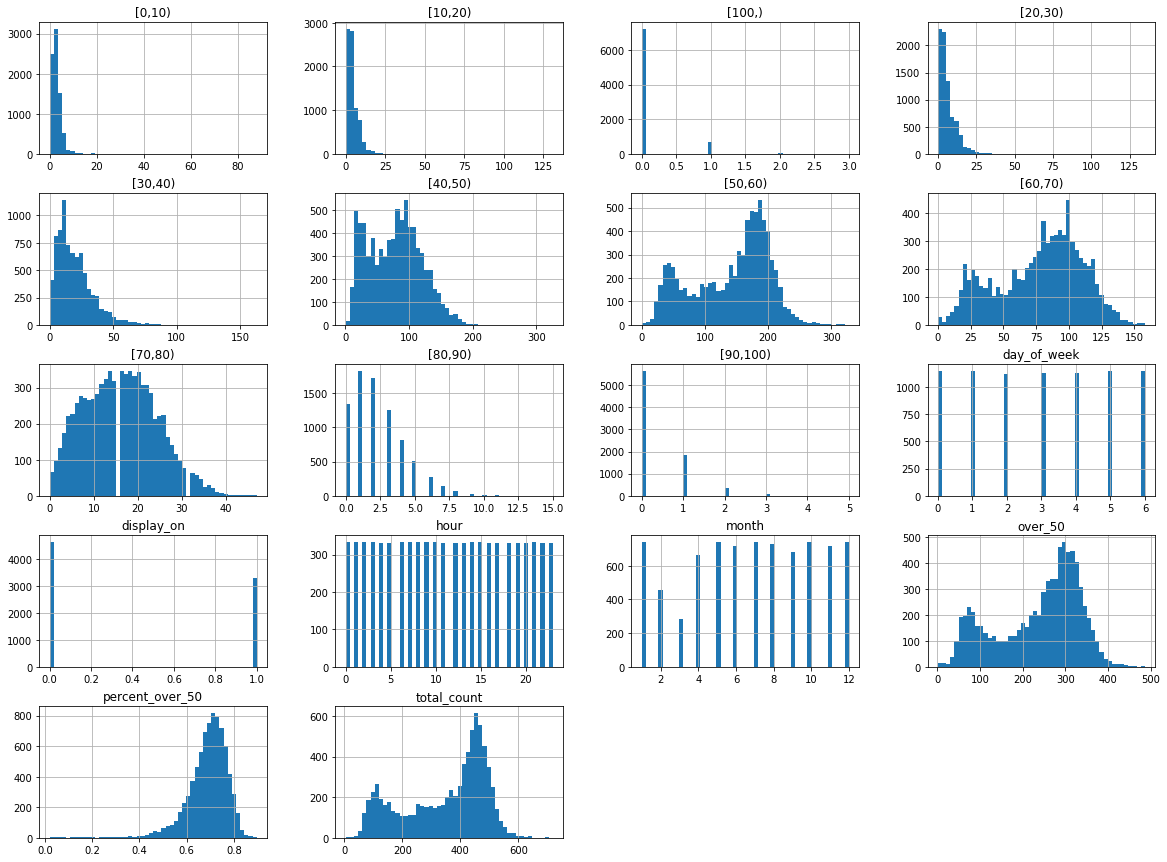

In [51]:
# Plot histograms

pivoted.hist(bins=50, figsize=(20,15))
plt.show()

# For the 'display_on' and 'month' columns: categories have different proportions in the dataset

**Check value counts for categorical attributes:**

In [52]:
# Values for display on and display off are not equally represented

pivoted['display_on'].value_counts()

0    4657
1    3316
Name: display_on, dtype: int64

In [53]:
# The 'display_on' category proportions in the full dataset

pivoted['display_on'].value_counts() / len(pivoted)

0    0.584096
1    0.415904
Name: display_on, dtype: float64

In [54]:
# Value counts for the 'hour' are almost the same

pivoted['hour'].value_counts()

8     335
7     334
9     334
21    333
10    333
1     333
2     333
6     333
0     333
14    333
3     333
15    333
18    332
22    332
5     332
4     332
19    331
17    331
13    331
20    331
12    331
11    330
16    330
23    330
Name: hour, dtype: int64

In [55]:
# Value counts for the 'day_of_week' are quite close

pivoted['day_of_week'].value_counts()

5    1152
0    1148
1    1145
6    1144
4    1131
3    1128
2    1125
Name: day_of_week, dtype: int64

In [56]:
# Data for the sign_id '230' was collected from 2019-03-20 06:00 to 2020-02-19 23:00.
# There are less entries for March 2019 and February 2020 in the dataset than for other months.

pivoted['month'].value_counts()

7     744
10    744
5     744
1     744
12    744
8     731
11    720
6     720
9     683
4     662
2     455
3     282
Name: month, dtype: int64

In [57]:
# The 'month' category proportions in the full dataset

pivoted['month'].value_counts() / len(pivoted)

# We can do stratified train-test split based on the 'month' category to keep the category proportions for training and testing

7     0.093315
10    0.093315
5     0.093315
1     0.093315
12    0.093315
8     0.091684
11    0.090305
6     0.090305
9     0.085664
4     0.083030
2     0.057068
3     0.035369
Name: month, dtype: float64

In [58]:
# What is the maximum hourly count for the speed bin '100 km/hr and higher'? - 3 vehicles observed in an hour
# Very high speeds were observed at different times of day

sorted_by_100 = pivoted.sort_values(by=['[100,)', '[90,100)'], ascending=False)
sorted_by_100.head(10)

speed_bin,"[0,10)","[10,20)","[100,)","[20,30)","[30,40)","[40,50)","[50,60)","[60,70)","[70,80)","[80,90)","[90,100)",month,day_of_week,hour,display_on,total_count,over_50,percent_over_50
datetime_bin,,,,,,,,,,,,,,,,,,
2019-06-20T11:00,3,6,3,9,26,101,180,109,29,2,1,6,4,11,1,469,324,0.690832
2019-08-04T00:00,5,4,3,4,4,46,91,65,25,4,1,8,0,0,0,252,189,0.750000
2019-05-14T20:00,2,4,2,8,26,78,134,109,28,7,3,5,2,20,1,401,283,0.705736
2019-11-03T14:00,3,5,2,5,9,99,202,136,26,5,3,11,0,14,0,495,374,0.755556
2019-12-19T06:00,5,10,2,10,27,67,170,138,37,5,3,12,4,6,0,474,355,0.748945
2019-04-02T10:00,1,5,2,11,25,110,148,78,20,2,2,4,2,10,1,404,252,0.623762
2019-06-14T20:00,3,2,2,3,17,85,168,101,22,7,2,6,5,20,1,412,302,0.733010
2019-07-05T06:00,1,2,2,7,17,71,179,142,44,8,2,7,5,6,0,475,377,0.793684
2019-07-20T14:00,1,2,2,4,11,61,201,127,24,2,2,7,6,14,0,437,358,0.819222


Text(0, 0.5, 'Number of vehicles')

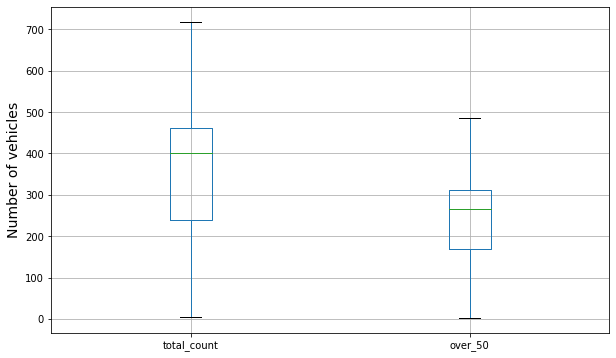

In [59]:
# Box plots for the 'total_count' and 'over_50'

pd.plotting.boxplot(pivoted.iloc[:, -3:-1], figsize=(10,6))
plt.ylabel('Number of vehicles', fontsize=14)

Text(0, 0.5, 'Percentage')

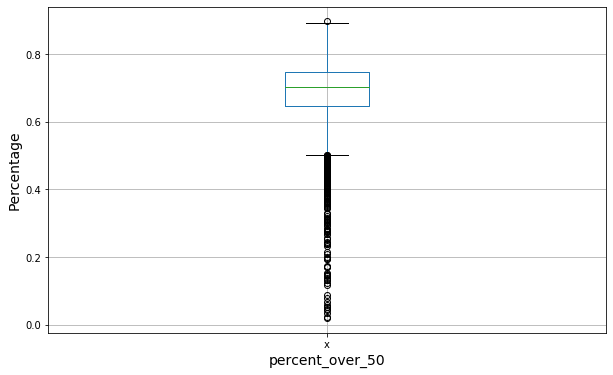

In [60]:
# Box plot for the 'percent_over_50'

pd.plotting.boxplot(pivoted['percent_over_50'], figsize=(10,6))
plt.xlabel('percent_over_50', fontsize=14)
plt.ylabel('Percentage', fontsize=14)

In [61]:
# Group the data by "display_on":
# Average hourly count of vehicles in speed bin 'over_50' is much greater when display is active.
# However, the average proportion of such vehicles is slightly higher when display is inactive than when it is active.

grouped_display = pivoted.groupby(pivoted['display_on']).agg(['mean', 'max'])
grouped_display

[0,10)       [10,20)         [100,)       [20,30)       \
                mean max      mean  max      mean max      mean  max   
display_on                                                             
0           3.114881  79  3.081598  105  0.122182   3  3.721495   84   
1           2.992762  88  6.343788  131  0.070265   3  9.784077  135   

              [30,40)          [40,50)          [50,60)         [60,70)       \
                 mean  max        mean  max        mean  max       mean  max   
display_on                                                                     
0           12.837664  146   54.939661  191  111.313292  281  67.030277  158   
1           29.868215  163  109.859771  326  183.774125  328  92.724065  157   

              [70,80)       [80,90)      [90,100)         month      \
                 mean max      mean max      mean max      mean max   
display_on                                                            
0           14.999356  47  2.299549  11  0.384582   5  6.860855  12   
1           17.560314  45  2.309107  15  0.332328   4  6.854041  12   

           day_of_week           hour     total_count          over_50       \
                  mean max       mean max        mean  max        mean  max   
display_on                                                                    
0             2.999141   6  10.059480  23  273.844535  570  196.149238  420   
1             3.003619   5  13.489747  20  455.618818  719  296.770205  486   

           percent_over_50            
                      mean       max  
display_on                            
0                 0.712120  0.896226  
1                 0.653263  0.891892

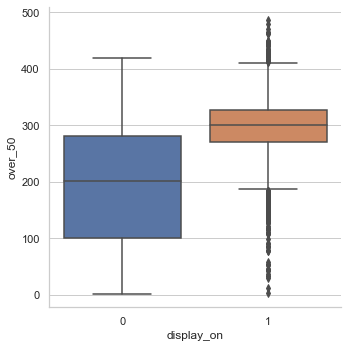

In [62]:
# Box plot of the 'over_50' by display on/off

sns.set(style="whitegrid")
sns.catplot(x='display_on', y='over_50', kind='box', data=pivoted)

Text(0, 0.5, 'over_50')

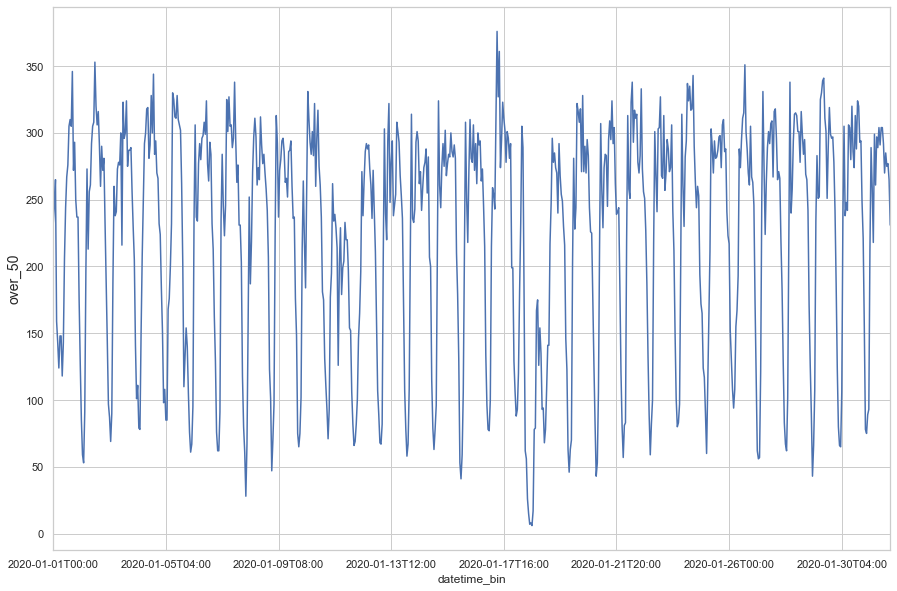

In [63]:
# Plot how the 'over_50' values changed during January 2020

pivoted['over_50'][pivoted.month == 1].plot(figsize=(15,10))
plt.ylabel('over_50', fontsize=14)

In [64]:
# The lowest 'over_50' count in January 2020

pivoted['over_50'][pivoted.month == 1].min()

6

In [65]:
# When was it observed? - 2020-01-18, from 5pm to 6pm, Saturday

pivoted[(pivoted.month == 1) & (pivoted.over_50 == 6)]

speed_bin,"[0,10)","[10,20)","[100,)","[20,30)","[30,40)","[40,50)","[50,60)","[60,70)","[70,80)","[80,90)","[90,100)",month,day_of_week,hour,display_on,total_count,over_50,percent_over_50
datetime_bin,,,,,,,,,,,,,,,,,,
2020-01-18T17:00,0,19,0,84,128,55,6,0,0,0,0,1,6,17,0,292,6,0.020548


In [66]:
# The highest 'over_50' count in January 2020

pivoted['over_50'][pivoted.month == 1].max()

376

In [67]:
# When was it observed? - 2020-01-17, from 10am to 11am, Friday (display active)

pivoted[(pivoted.month == 1) & (pivoted.over_50 == 376)]

speed_bin,"[0,10)","[10,20)","[100,)","[20,30)","[30,40)","[40,50)","[50,60)","[60,70)","[70,80)","[80,90)","[90,100)",month,day_of_week,hour,display_on,total_count,over_50,percent_over_50
datetime_bin,,,,,,,,,,,,,,,,,,
2020-01-17T10:00,2,7,0,10,31,93,235,120,19,2,0,1,5,10,1,519,376,0.72447


Text(0, 0.5, 'total_count')

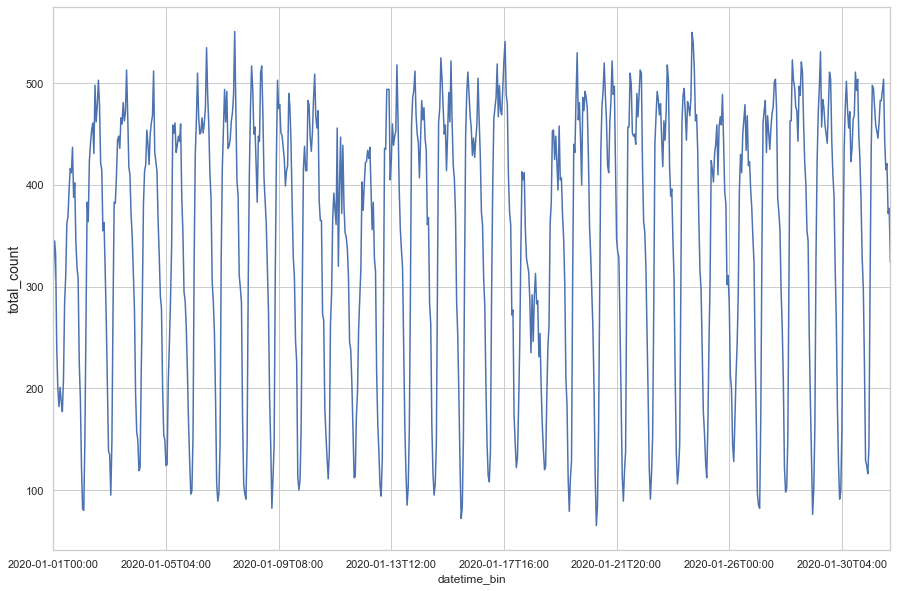

In [68]:
# Plot how the 'total_count' values changed during January 2020

pivoted['total_count'][pivoted.month == 1].plot(figsize=(15,10))
plt.ylabel('total_count', fontsize=14)

Text(0, 0.5, 'percent_over_50')

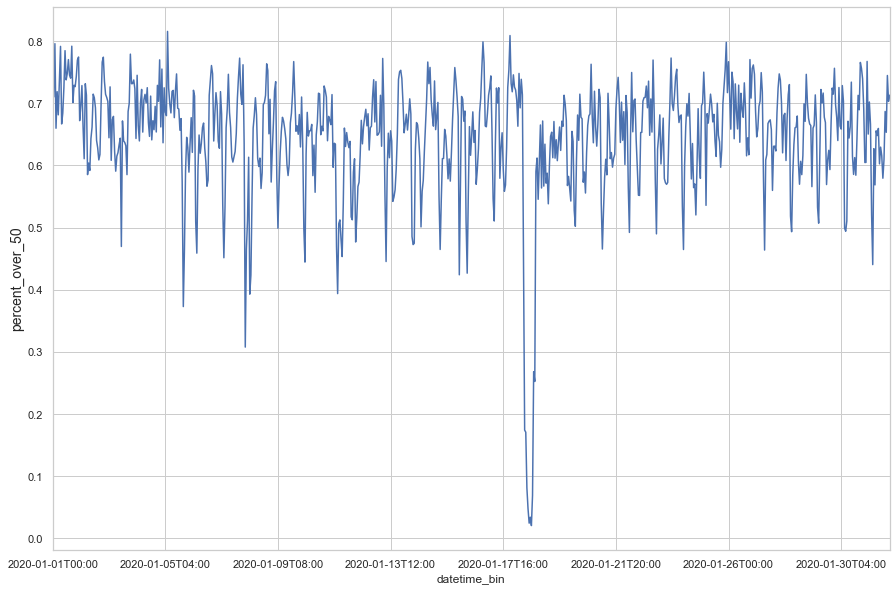

In [69]:
# Plot how the 'percent_over_50' values changed during January 2020

pivoted['percent_over_50'][pivoted.month == 1].plot(figsize=(15,10))
plt.ylabel('percent_over_50', fontsize=14)

In [70]:
# Group the data by hour

grouped_hour = pivoted[['total_count', 'over_50', 'percent_over_50']].groupby(pivoted['hour']).mean()
grouped_hour

speed_bin,total_count,over_50,percent_over_50
hour,,,
0,202.291291,143.273273,0.704975
1,141.048048,99.222222,0.695086
2,106.693694,75.039039,0.694676
3,103.645646,72.384384,0.697174
4,121.704819,83.030120,0.688526
5,226.740964,164.487952,0.724902
6,356.660661,252.843844,0.714900
7,399.101796,242.161677,0.623457
8,442.785075,258.032836,0.597582


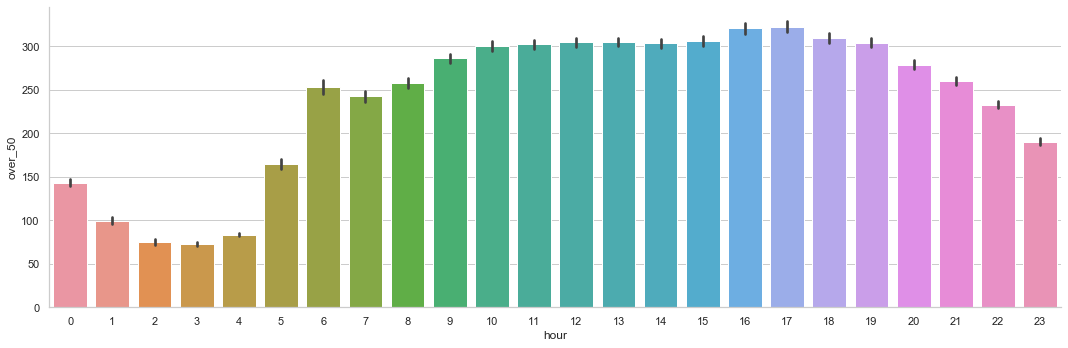

In [71]:
sns.catplot(x='hour', y='over_50', kind='bar', data=pivoted, aspect=3)

# The highest values are observed for hours 4pm-5pm and 5pm-6pm

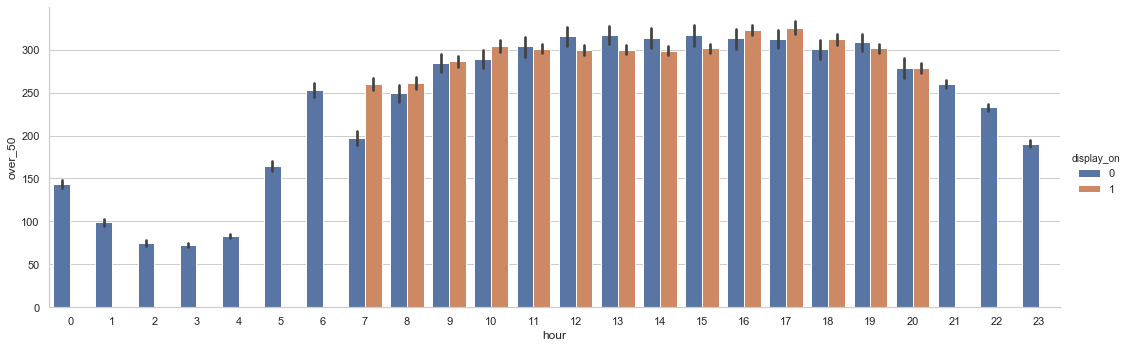

In [72]:
# Average hourly counts of vehicles in speed bin 'over_50' grouped by hour and by display on/off

sns.catplot(x='hour', y='over_50', hue='display_on', kind='bar', data=pivoted, aspect=3)

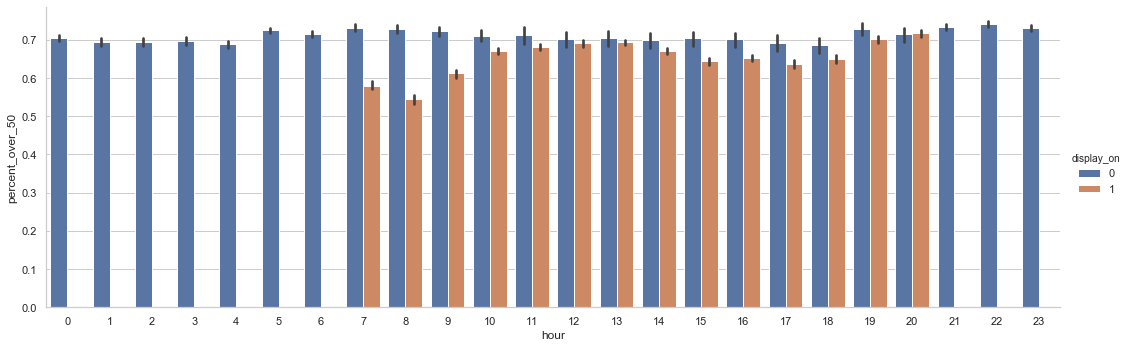

In [73]:
# Average proportion of vehicles with speeds of 50 km/hr and higher grouped by hour and by display on/off:

# Average proportions of vehicles with speeds of 50 km/hr and higher are greater than 50% for all 'hour' values.
# The average percentage is mostly higher when display is off.

sns.catplot(x='hour', y='percent_over_50', hue='display_on', kind='bar', data=pivoted, aspect=3)

In [74]:
# Group the data by day of week:
# After grouping, the highest 'over_50' value is observed for Friday and the highest 'percent_over_50' value - for Sunday.

grouped_day = pivoted[['total_count', 'over_50', 'percent_over_50']].groupby(pivoted['day_of_week']).mean()
grouped_day

speed_bin,total_count,over_50,percent_over_50
day_of_week,,,
0,316.364111,230.618467,0.730317
1,340.864629,229.231441,0.679066
2,356.285333,236.736889,0.670607
3,359.585106,238.915780,0.671883
4,361.502210,238.068966,0.666062
5,369.480903,249.506944,0.681557
6,342.409091,242.852273,0.713146


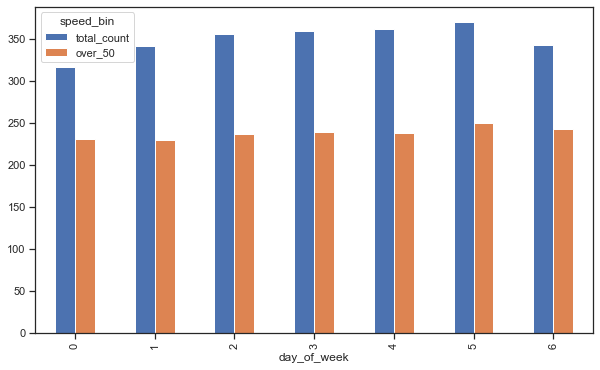

In [75]:
# Average hourly counts of all vehicles and counts of vehicles with speeds of 50 km/hr and higher grouped by day of week

sns.set(style="ticks")
grouped_day[['total_count', 'over_50']].plot.bar(figsize=(10,6))

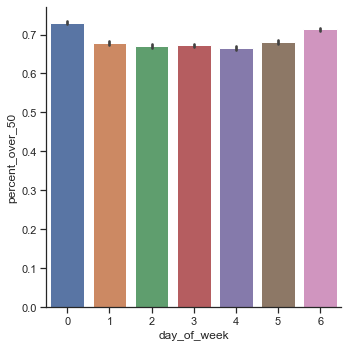

In [76]:
# The 'percent_over_50' data grouped by day of week

sns.catplot(x='day_of_week', y='percent_over_50', kind='bar', data=pivoted)

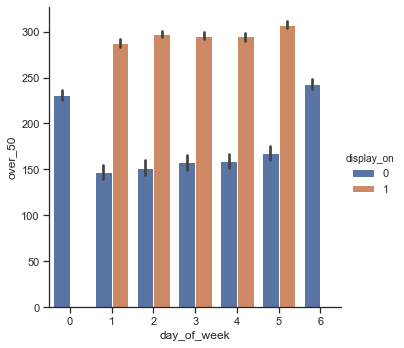

In [77]:
# Average hourly counts of vehicles in speed bin 'over_50' grouped by day of week and by display on/off:
# On weekends display is off
# On weekdays, the average counts are higher when display is on (7am-9pm)

sns.catplot(x='day_of_week', y='over_50', hue='display_on', kind='bar', data=pivoted)

In [78]:
# Group the data by month

grouped_month = pivoted[['total_count', 'over_50', 'percent_over_50']].groupby(pivoted['month']).mean()
grouped_month

speed_bin,total_count,over_50,percent_over_50
month,,,
1,351.918011,224.841398,0.645209
2,357.140659,229.872527,0.637721
3,305.489362,204.790780,0.681449
4,303.184290,204.268882,0.687308
5,373.545699,238.743280,0.644999
6,352.677778,248.097222,0.703185
7,361.096774,264.139785,0.728249
8,351.998632,260.833105,0.742939
9,340.877013,239.313324,0.719378


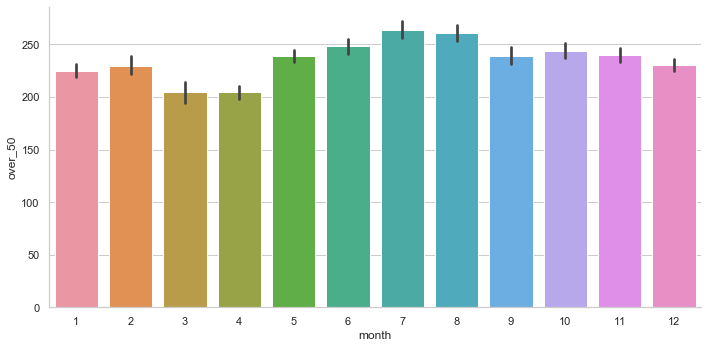

In [79]:
sns.set(style="whitegrid")
sns.catplot(x='month', y='over_50', kind='bar', data=pivoted, aspect=2)

# The highest values are observed for July and August - months when the school is closed

### Split data into training and testing sets

In [80]:
# Create a DataFrame containing the features ('hour', 'day_of_week', 'month') and a target ('over_50').
# The attribute 'display_on' was not included because it is related to the 'hour' and the 'day_of_week'

df = pivoted[['hour', 'day_of_week', 'month', 'over_50']].copy()
df.head()

speed_bin,hour,day_of_week,month,over_50
datetime_bin,,,,
2019-03-20T06:00,6,3,3,152
2019-03-20T07:00,7,3,3,55
2019-03-20T08:00,8,3,3,153
2019-03-20T09:00,9,3,3,285
2019-03-20T10:00,10,3,3,273


In [81]:
# Reset the index of the DataFrame and use the default one instead (to prepare for stratified train-test split)

df2 = df.reset_index(drop=True)

In [82]:
df2.head()

speed_bin,hour,day_of_week,month,over_50
0,6,3,3,152
1,7,3,3,55
2,8,3,3,153
3,9,3,3,285
4,10,3,3,273


In [83]:
# Stratified sampling based on the 'month' category

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_index, test_index in split.split(df2, df2['month']):
    train_set = df2.loc[train_index]
    test_set = df2.loc[test_index]

In [84]:
# The 'month' category proportions in the training set

train_set['month'].value_counts() / len(train_set)

7     0.093289
10    0.093289
5     0.093289
1     0.093289
12    0.093289
8     0.091722
11    0.090310
6     0.090310
9     0.085607
4     0.083098
2     0.057071
3     0.035434
Name: month, dtype: float64

In [85]:
# The 'month' category proportions in the test set

test_set['month'].value_counts() / len(test_set)

12    0.093417
10    0.093417
7     0.093417
5     0.093417
1     0.093417
8     0.091536
11    0.090282
6     0.090282
9     0.085893
4     0.082759
2     0.057053
3     0.035110
Name: month, dtype: float64

In [86]:
train_set.head()

speed_bin,hour,day_of_week,month,over_50
1008,16,5,5,374
3117,13,2,7,346
7510,16,5,1,304
6898,4,1,1,95
6735,9,1,12,257


In [87]:
# Summary statistics for the training set

train_set.describe()

speed_bin,hour,day_of_week,month,over_50
count,6378.000000,6378.000000,6378.000000,6378.000000
mean,11.556287,3.005801,6.857479,238.069771
std,6.947577,2.000580,3.405284,95.658963
min,0.000000,0.000000,1.000000,2.000000
25%,6.000000,1.000000,4.000000,170.000000
50%,12.000000,3.000000,7.000000,265.000000
75%,18.000000,5.000000,10.000000,311.000000
max,23.000000,6.000000,12.000000,463.000000


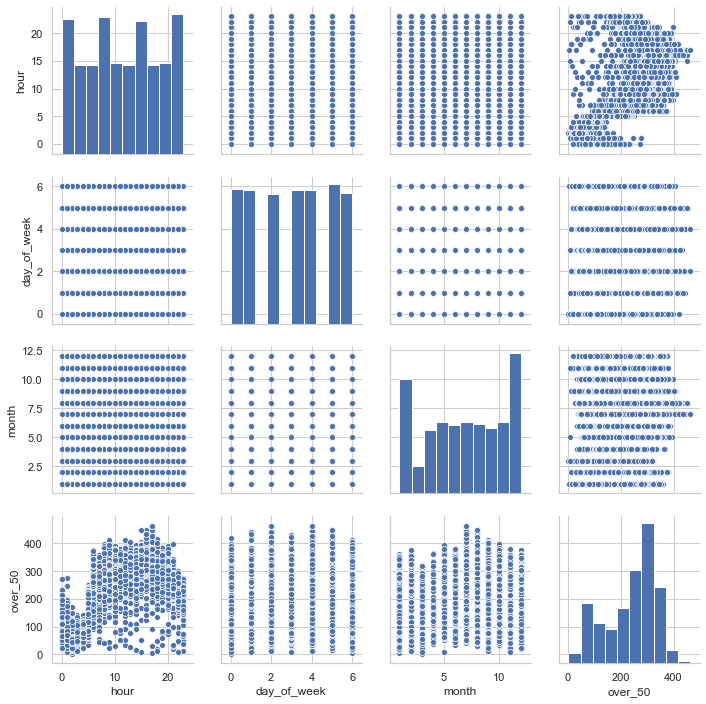

In [88]:
# Scatter plot matrix for the training set

sns.pairplot(train_set)

In [89]:
# Correlation matrix for the training set.

train_set.corr()

speed_bin,hour,day_of_week,month,over_50
speed_bin,,,,
hour,1.000000,-0.004204,-0.012185,0.556745
day_of_week,-0.004204,1.000000,-0.009800,0.050076
month,-0.012185,-0.009800,1.000000,0.063594
over_50,0.556745,0.050076,0.063594,1.000000


In [90]:
# Write the training and test sets to csv files so that they can be used in the Notebook 2

train_set.to_csv('data_school_safety_zones/train_set.csv')
test_set.to_csv('data_school_safety_zones/test_set.csv')

### Please see the notebook scs3253_project_group6_notebook2.ipynb (it contains further data preparation and models)